## Caricamento file e librerie



In [0]:
# versione keras 2.3.0
%tensorflow_version  2.x
!pip install -q keras==2.3.0

TensorFlow 2.x selected.
     |████████████████████████████████| 378kB 19.8MB/s 


### Caricamento file da drive

In [0]:
# mount Drive
import zipfile
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# unzip file audio drive
!unzip '/content/drive/My Drive/Progetto DSIM/Audio/Dati/Audio_Dataset3.zip'

### Caricamento librerie

In [0]:
import os
import numpy as np
import random
import pandas as pd
from time import time
from scipy.io import wavfile as wav
from tqdm import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd

# SKLEARN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing

# AUDIO
import librosa

# KERAS
from keras.models import Model, load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import adam
from keras.utils import to_categorical

Using TensorFlow backend.


## Definizione funzioni

In [0]:
# Funzione aggiunta rumore
def add_noise(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

# Funzione caricamento dati per versione con features MFCC
def load_data(dir = './Audio_Dataset/', n_mfcc = 13, augmented = False):
  # liste label e segnali
  labels = []
  signals = []

  # caricamento dati da cartella
  for f in tqdm(sorted(os.listdir(dir))):
      if f.endswith('.wav'):
        # Carica file ed estrae le feature
        signal, sr = librosa.load(dir + f, mono=True, sr = 44100)
        # Calcola coefficiente MFCC
        mfcc = librosa.feature.mfcc(signal*1.0, sr=int(sr), n_mfcc = n_mfcc)
        # Riconoscimento label
        label = f.split('_')[0]
        # Append alle liste
        signals.append(mfcc)
        labels.append(int(label))
        
        # Augmentation dei dati
        if(augmented):
          random.seed(2020)
          # aggiunta rumore casuale
          noise = random.uniform(0.001, 0.01)
          signal_noise = add_noise(signal, noise)
          # Calcola coefficiente MFCC
          mfcc_noise = librosa.feature.mfcc(signal_noise*1.0, sr=int(sr), n_mfcc = n_mfcc)
          # Append alle liste
          signals.append(mfcc_noise)
          labels.append(int(label))

  return signals, labels

# Definizione funzioni per calcolo feature
def energy(input):
  return np.sum((input*1.0)**2, keepdims=True)

def sdev(input):
  return np.std(input, keepdims=True)

def aavg(input):
  return np.mean(np.abs(input), keepdims=True)

def create_features(signal, sr):
  audio_energy = energy(signal)
  audio_sdev = sdev(signal)
  audio_aavg = aavg(signal)
  audio_zcr = np.mean(librosa.feature.zero_crossing_rate(signal), axis = 1)
  audio_stft = np.abs(librosa.stft(signal)) #prendo il valore assoluto per ottenere la magnitudine della frequenza per ogni bin considerato
  audio_contrast = np.mean(librosa.feature.spectral_contrast(S=audio_stft, sr=sr).T,axis=0)
  audio_mfccs_mean = np.mean(librosa.feature.mfcc(signal*1.0, sr=sr, n_mfcc=13).T,axis=0)
  audio_mfccs_sdev = np.std(librosa.feature.mfcc(signal*1.0, sr=sr, n_mfcc=13).T,axis=0)
  audio_tonnetz = np.mean(librosa.feature.tonnetz(signal, sr=sr).T,axis=0) #features dello spazio tonale
  return(np.concatenate((audio_energy, audio_sdev, audio_aavg, audio_zcr, audio_contrast, audio_mfccs_mean, audio_mfccs_sdev, audio_tonnetz)))


# Funzione caricamento dati per versione con features multiple
def load_data_complesso(dir = './Audio_Dataset/', augmented = False):
  # liste label e segnali
  labels = []
  signals = []

  # caricamento dati da cartella
  for f in tqdm(sorted(os.listdir(dir))):
      if f.endswith('.wav'):
        # Carica file ed estrae le feature
        sr, signal = wav.read(dir+f)
        # Elaborazione segnale per estrazione features
        features = create_features(signal, sr) 
        # Riconoscimento label
        label = f.split('_')[0]
        # Append alle liste
        signals.append(features)
        labels.append(int(label))
        
        # Augmentation dei dati
        if(augmented == True):
          random.seed(2020)
          # aggiunta rumore casuale
          noise = random.uniform(0.001, 0.01)
          signal_aug = add_noise(signal, noise)
          # Elaborazione segnale per estrazione features
          features_aug = create_features(signal_aug, sr)
          # Append alle liste
          signals.append(features_aug)
          labels.append(int(label))

  return signals, labels

# Funzione split train and test con preprocessing (per CNN)
def split(signal, label, complesso = False):
  # train e test split
  x_train, x_test, y_train, y_test = train_test_split(signal, label, test_size=0.20, random_state=2020, shuffle = True)
  
  # reshape
  if(complesso):
    x_train = np.array(x_train)
    x_test = np.array(x_test)
  else:
    image_size_0 = x_train[0].shape[0]
    image_size_1 = x_train[0].shape[1]
    x_train = np.array(list(x_train)).reshape(-1, image_size_0, image_size_1, 1)
    x_test = np.array(list(x_test)).reshape(-1, image_size_0, image_size_1, 1)
  
  # scale data
  eps = 0.001
  x_train = np.array(x_train)
  x_train_mean = x_train.mean(axis=0)
  x_train_std = x_train.std(axis=0)
  x_train = (x_train - x_train_mean + eps)/(x_train_std + eps)
  x_train = [row for row in x_train]
  x_test = [row for row in (np.array(x_test) - x_train_mean + eps)/(x_train_std + eps)]

  return np.array(x_train), np.array(x_test), y_train, y_test

## Classificatori CNN

### Senza Augmentation

#### Creazione dati

In [0]:
signal, label = load_data()
print(str(len(signal)) + " " + str(len(label)))

100%|██████████| 602/602 [01:45<00:00,  5.80it/s]

602 602


In [0]:
# split train e test (80-20)
x_train, x_test, y_train, y_test = split(signal, label)
print("Train shape: " + str(np.array(x_train).shape) + " " + str(np.array(y_train).shape))
print("Test shape: " + str(np.array(x_test).shape) + " " + str(np.array(y_test).shape))

Train shape: (481, 13, 173, 1) (481,)
Test shape: (121, 13, 173, 1) (121,)


#### Modello CNN

##### Crazione e compilazione modello

In [0]:
input_shape = x_train[0].shape

# Definizione modello
model = Sequential()

# Primo blocco conv
model.add(Conv2D(32,
                 kernel_size=(2, 2),
                 activation='relu',
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Secondo blocco conv
model.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Terzo blocco conv
model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Pooling
model.add(GlobalAveragePooling2D())

# Blocco Dense
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 12, 172, 32)       160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 172, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 86, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 86, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 85, 64)         8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 85, 64)         256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 42, 64)        

In [0]:
# Compilazione modello
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = adam(lr = 0.0001),
              metrics=['accuracy'])

# Train e test modello
mcp_save = ModelCheckpoint('modello-1.hdf5',
                           save_best_only=True,
                           monitor='val_loss',
                           mode='min')

network_history = model.fit(
                            x_train, y_train,
                            batch_size= 64,
                            epochs= 200,
                            verbose = 1,
                            validation_split = 0.2,
                            callbacks = [mcp_save]
                          )

Train on 384 samples, validate on 97 samples
Epoch 1/200
384/384 [==============================] - 8s 21ms/step - loss: 0.7345 - accuracy: 0.5052 - val_loss: 0.6945 - val_accuracy: 0.4536
Epoch 2/200
384/384 [==============================] - 0s 251us/step - loss: 0.7021 - accuracy: 0.5182 - val_loss: 0.7052 - val_accuracy: 0.3814
Epoch 3/200
384/384 [==============================] - 0s 256us/step - loss: 0.6839 - accuracy: 0.5729 - val_loss: 0.7127 - val_accuracy: 0.3814
Epoch 4/200
384/384 [==============================] - 0s 247us/step - loss: 0.6600 - accuracy: 0.5885 - val_loss: 0.7168 - val_accuracy: 0.3814
Epoch 5/200
384/384 [==============================] - 0s 246us/step - loss: 0.6752 - accuracy: 0.5703 - val_loss: 0.7181 - val_accuracy: 0.3814
Epoch 6/200
384/384 [==============================] - 0s 240us/step - loss: 0.6389 - accuracy: 0.6198 - val_loss: 0.7168 - val_accuracy: 0.3814
Epoch 7/200
384/384 [==============================] - 0s 248us/step - loss: 0.6178 - 

##### Valutazione miglior modello

In [0]:
loaded_model = load_model("modello-1.hdf5")
loaded_model.evaluate(x_test, y_test, verbose=0)

[0.25681707657073155, 0.9090909361839294]

In [0]:
print(classification_report(y_test, loaded_model.predict_classes(x_test)))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90        59
           1       0.88      0.95      0.91        62

    accuracy                           0.91       121
   macro avg       0.91      0.91      0.91       121
weighted avg       0.91      0.91      0.91       121



##### Grafico train

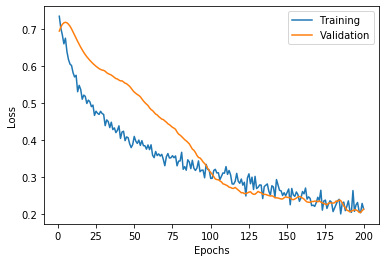

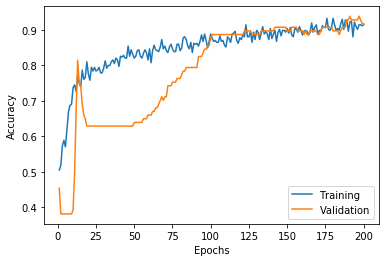

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

x_plot = list(range(1,len(network_history.epoch)+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

###Con Augmentation

#### Creazione dati

In [0]:
signal, label = load_data(augmented = True)
print(str(len(signal)) + " " + str(len(label)))

100%|██████████| 602/602 [02:14<00:00,  4.39it/s]

1204 1204


In [0]:
# Train-test split (80-20)
x_train, x_test, y_train, y_test = split(signal, label)
print("Train shape: " + str(np.array(x_train).shape) + " " + str(np.array(y_train).shape))
print("Test shape: " + str(np.array(x_test).shape) + " " + str(np.array(y_test).shape))

Train shape: (842, 13, 173, 1) (842,)
Test shape: (362, 13, 173, 1) (362,)


#### Modello CNN

##### Crazione e compilazione modello

In [0]:
input_shape = x_train[0].shape

# Definizione modello
model = Sequential()

# Primo blocco conv
model.add(Conv2D(64,
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.4))

# Secondo blocco conv
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.4))

# Pooling
model.add(GlobalAveragePooling2D())

# Dense
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 11, 171, 64)       640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 57, 64)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 3, 57, 64)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 55, 32)         18464     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 55, 32)         0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 32)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)               

In [0]:
# Compilazione modello
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = adam(lr = 0.001),
              metrics=['accuracy'])

# Train e test modello
mcp_save = ModelCheckpoint('Model-Audio-CNN-2.hdf5',
                           save_best_only=True,
                           monitor='val_loss',
                           mode='min')

network_history = model.fit(x_train, y_train,
                            batch_size= 32,
                            epochs= 500,
                            verbose = 1,
                            validation_split = 0.1,
                            callbacks = [mcp_save])

Train on 757 samples, validate on 85 samples
Epoch 1/500
757/757 [==============================] - 0s 646us/step - loss: 0.7000 - accuracy: 0.5020 - val_loss: 0.6868 - val_accuracy: 0.5294
Epoch 2/500
757/757 [==============================] - 0s 225us/step - loss: 0.6877 - accuracy: 0.5469 - val_loss: 0.6834 - val_accuracy: 0.5294
Epoch 3/500
757/757 [==============================] - 0s 204us/step - loss: 0.6852 - accuracy: 0.5376 - val_loss: 0.6689 - val_accuracy: 0.5412
Epoch 4/500
757/757 [==============================] - 0s 191us/step - loss: 0.6760 - accuracy: 0.5945 - val_loss: 0.6482 - val_accuracy: 0.7176
Epoch 5/500
757/757 [==============================] - 0s 188us/step - loss: 0.6553 - accuracy: 0.6182 - val_loss: 0.6795 - val_accuracy: 0.4706
Epoch 6/500
757/757 [==============================] - 0s 194us/step - loss: 0.6457 - accuracy: 0.6579 - val_loss: 0.6263 - val_accuracy: 0.6706
Epoch 7/500
757/757 [==============================] - 0s 190us/step - loss: 0.6343 -

##### Valutazione miglior modello

In [0]:
loaded_model = load_model("Model-Audio-CNN.hdf5")
loaded_model.evaluate(x_test, y_test, verbose=0)

[0.24140317598100525, 0.90055251121521]

In [0]:
print(classification_report(y_test, loaded_model.predict_classes(x_test)))

              precision    recall  f1-score   support

           0       0.95      0.85      0.89       181
           1       0.86      0.96      0.91       181

    accuracy                           0.90       362
   macro avg       0.91      0.90      0.90       362
weighted avg       0.91      0.90      0.90       362



##### Grafico train

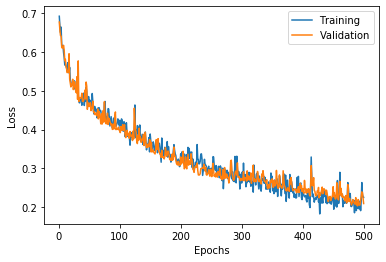

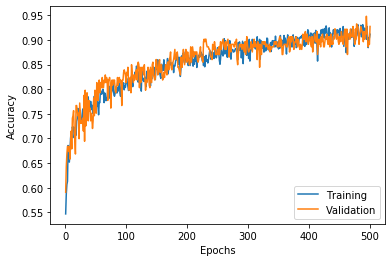

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

x_plot = list(range(1,len(network_history.epoch)+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

## Classificatore Audio con rete neurale Fully Connected

### Senza Augmentation

Caricamento dei dati senza effettuare augmentation

In [0]:
signal, label = load_data_complesso()

100%|██████████| 602/602 [01:35<00:00,  6.47it/s]


In [0]:
print(str(len(signal)) + " " + str(len(label)))

602 602


#### Preparazione Dati per l'attività di Training

In [0]:
# Train-test split (80-20)
x_train, x_test, y_train, y_test = split(signal, label, complesso = True)
print("Train shape: " + str(np.array(x_train).shape) + " " + str(np.array(y_train).shape))
print("Test shape: " + str(np.array(x_test).shape) + " " + str(np.array(y_test).shape))

Train shape: (481, 43) (481,)
Test shape: (121, 43) (121,)


#### Rete neurale

In [0]:
# Definizione modello
model = Sequential()
model.add(Dense(16, input_shape = (43,), activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                704       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 34        
Total params: 738
Trainable params: 738
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# Compilazione modello
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = adam(lr = 0.0001),
              metrics=['accuracy'])

# Train e test modello
mcp_save = ModelCheckpoint('modello-complesso.hdf5',
                           save_best_only=True,
                           monitor='val_loss',
                           mode='min')

network_history = model.fit(x_train, y_train,
                            batch_size= 16,
                            epochs= 400,
                            verbose = 1,
                            validation_split = 0.2,
                            callbacks = [mcp_save]
                          )

Train on 384 samples, validate on 97 samples
Epoch 1/400
384/384 [==============================] - 0s 440us/step - loss: 0.9698 - accuracy: 0.4896 - val_loss: 0.8100 - val_accuracy: 0.5567
Epoch 2/400
384/384 [==============================] - 0s 185us/step - loss: 0.9359 - accuracy: 0.4896 - val_loss: 0.7953 - val_accuracy: 0.5567
Epoch 3/400
384/384 [==============================] - 0s 213us/step - loss: 0.9141 - accuracy: 0.5208 - val_loss: 0.7811 - val_accuracy: 0.5464
Epoch 4/400
384/384 [==============================] - 0s 224us/step - loss: 0.9196 - accuracy: 0.4896 - val_loss: 0.7682 - val_accuracy: 0.5361
Epoch 5/400
384/384 [==============================] - 0s 215us/step - loss: 0.8749 - accuracy: 0.5026 - val_loss: 0.7555 - val_accuracy: 0.5361
Epoch 6/400
384/384 [==============================] - 0s 195us/step - loss: 0.8832 - accuracy: 0.5026 - val_loss: 0.7434 - val_accuracy: 0.5361
Epoch 7/400
384/384 [==============================] - 0s 188us/step - loss: 0.8646 -

#### Valutazione miglior modello

In [0]:
loaded_model = load_model("modello-complesso.hdf5")
loaded_model.evaluate(x_test, y_test, verbose=0)

[0.24924773796777094, 0.942148745059967]

In [0]:
print(classification_report(y_test, loaded_model.predict_classes(x_test)))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94        59
           1       0.98      0.90      0.94        62

    accuracy                           0.94       121
   macro avg       0.94      0.94      0.94       121
weighted avg       0.95      0.94      0.94       121



#### Grafico train

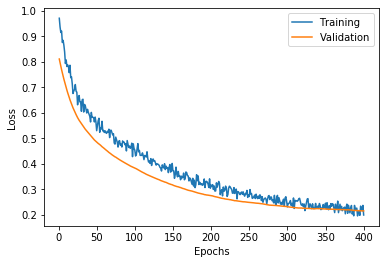

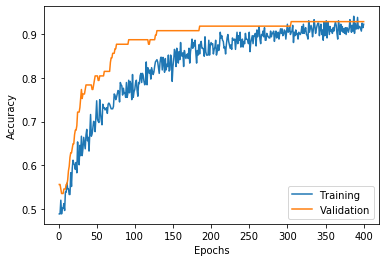

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

x_plot = list(range(1,len(network_history.epoch)+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

###Con Augmentation

Caricamento dei dati effettuando augmentation

In [0]:
signal, label = load_data_complesso(augmented=True)

100%|██████████| 602/602 [03:14<00:00,  3.18it/s]


In [0]:
print(str(len(signal)) + " " + str(len(label)))

1204 1204


#### Preparazione Dati per l'attività di Training

In [0]:
# Train-test split (80-20)
x_train, x_test, y_train, y_test = split(signal, label, complesso = True)
print("Train shape: " + str(np.array(x_train).shape) + " " + str(np.array(y_train).shape))
print("Test shape: " + str(np.array(x_test).shape) + " " + str(np.array(y_test).shape))

Train shape: (963, 43) (963,)
Test shape: (241, 43) (241,)


#### Rete neurale

In [0]:
# Definizione modello
model = Sequential()
model.add(Dense(16, input_shape = (43,), activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

print(model.summary())

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 16)                704       
_________________________________________________________________
dropout_44 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 2)                 34        
Total params: 738
Trainable params: 738
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# Compilazione modello
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = adam(lr = 0.0001),
              metrics=['accuracy'])

# Train e test modello
mcp_save = ModelCheckpoint('Model-Audio-FC.hdf5',
                           save_best_only=True,
                           monitor='val_loss',
                           mode='min')

network_history = model.fit(x_train, y_train,
                            batch_size= 32,
                            epochs= 500,
                            verbose = 1,
                            validation_split = 0.2,
                            callbacks = [mcp_save]
                          )

Train on 770 samples, validate on 193 samples
Epoch 1/500
770/770 [==============================] - 0s 265us/step - loss: 1.0949 - accuracy: 0.4961 - val_loss: 1.0716 - val_accuracy: 0.5130
Epoch 2/500
770/770 [==============================] - 0s 102us/step - loss: 1.0362 - accuracy: 0.4948 - val_loss: 1.0318 - val_accuracy: 0.5181
Epoch 3/500
770/770 [==============================] - 0s 108us/step - loss: 1.0244 - accuracy: 0.5065 - val_loss: 0.9977 - val_accuracy: 0.5285
Epoch 4/500
770/770 [==============================] - 0s 97us/step - loss: 0.9534 - accuracy: 0.5117 - val_loss: 0.9657 - val_accuracy: 0.5389
Epoch 5/500
770/770 [==============================] - 0s 96us/step - loss: 0.9820 - accuracy: 0.5065 - val_loss: 0.9356 - val_accuracy: 0.5492
Epoch 6/500
770/770 [==============================] - 0s 105us/step - loss: 0.9272 - accuracy: 0.5312 - val_loss: 0.9071 - val_accuracy: 0.5492
Epoch 7/500
770/770 [==============================] - 0s 106us/step - loss: 0.9396 - 

#### Valutazione miglior modello

In [0]:
loaded_model = load_model("Model-Audio-FC.hdf5")
loaded_model.evaluate(x_test, y_test, verbose=0)

[0.3384399963117734, 0.8589211702346802]

In [0]:
print(classification_report(y_test, loaded_model.predict_classes(x_test)))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       115
           1       0.89      0.83      0.86       126

    accuracy                           0.86       241
   macro avg       0.86      0.86      0.86       241
weighted avg       0.86      0.86      0.86       241



#### Grafico train

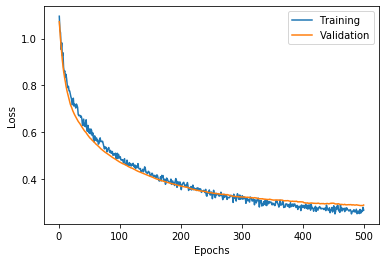

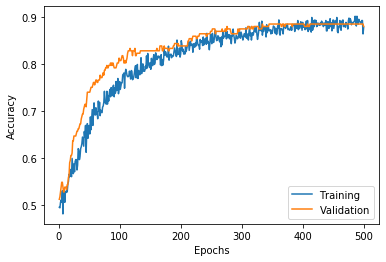

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

x_plot = list(range(1,len(network_history.epoch)+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)